# 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам в Classroom

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- [Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/winequality-red.csv.gz', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


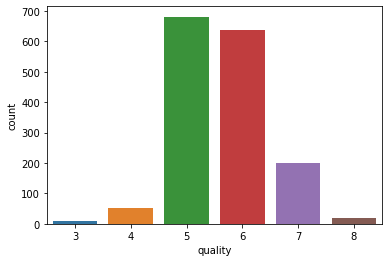

In [3]:
sns.countplot(df.quality)

Классы не сбалансированны. Низкого и высокго качества вин гораздо меньше "нормальных". Ну оно и в жизни так обосновано спросом.

In [6]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

In [4]:
X= df.drop(['quality'],axis=1)
y= df['quality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [145]:
def GridSearchModel(model, params, X, y, n_splits=5):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    search = GridSearchCV(model, params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    
    %time search.fit(X, y)
    model_name = '{}'.format(model).split('(')[0]
    print("{}\n\nBEST:\nmean_test_score={}\nparams={}".format(model_name,search.best_score_, search.best_params_))
    #return search

 - KNeighborsClassifier с 10 соседями

In [108]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,3,4]
         }
GridSearchModel(KNeighborsClassifier(), params, X=X_train, y=y_train)

CPU times: user 72.5 ms, sys: 125 µs, total: 72.7 ms
Wall time: 606 ms
KNeighborsClassifier

BEST:
mean_test_score=0.506111714844599
params={'n_neighbors': 10, 'p': 1}


 - KNeighborsClassifier с 10 соседями и масштабированием StandartScaler

In [109]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

GridSearchModel(KNeighborsClassifier(), params, X=scaled_X_train, y=y_train)

CPU times: user 55.4 ms, sys: 94 µs, total: 55.5 ms
Wall time: 1.16 s
KNeighborsClassifier

BEST:
mean_test_score=0.58547707020213
params={'n_neighbors': 10, 'p': 2}


 - RidgeClassifier

In [110]:
params = {
            "alpha": np.arange(0,5,0.05),
            "normalize": [True,False]
         }
GridSearchModel(RidgeClassifier(), params, X=X_train, y=y_train)

CPU times: user 1.03 s, sys: 31.6 ms, total: 1.07 s
Wall time: 4.03 s
RidgeClassifier

BEST:
mean_test_score=0.5817778743751358
params={'alpha': 0.45, 'normalize': False}


 - DecisionTreeClassifier 

In [114]:
params = {
            "max_depth": np.linspace(1, 32, 20, endpoint=True),
            "min_samples_split": np.linspace(0.05, 1.0, 10, endpoint=True),
            "max_features": list(range(1,X_train.shape[1]))
         }
GridSearchModel(DecisionTreeClassifier(), params, X=X_train, y=y_train)

CPU times: user 9.27 s, sys: 93.3 ms, total: 9.36 s
Wall time: 26.5 s
DecisionTreeClassifier

BEST:
mean_test_score=0.6041773527494023
params={'max_depth': 18.94736842105263, 'max_features': 6, 'min_samples_split': 0.15555555555555556}


 - BaggingClassifier c 100 деревьев

In [132]:
params = {
            "n_estimators": [100],
            'max_samples' : [0.5, 0.6, 0.8, 1.0]
         }
GridSearchModel(BaggingClassifier(), params, X=X_train, y=y_train)

CPU times: user 682 ms, sys: 0 ns, total: 682 ms
Wall time: 5.76 s
BaggingClassifier

BEST:
mean_test_score=0.6667420126059552
params={'max_samples': 0.8, 'n_estimators': 100}


 - BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков.  

In [152]:
params = {
            "n_estimators": [100],
            'max_samples' : [0.5, 0.6, 0.8, 1.0],
            "max_features": [int(X_train.shape[1]/2)]    
         }
GridSearchModel(BaggingClassifier(), params, X=X_train, y=y_train)

CPU times: user 498 ms, sys: 7.87 ms, total: 506 ms
Wall time: 4.55 s
BaggingClassifier

BEST:
mean_test_score=0.6723407954792436
params={'max_features': 5, 'max_samples': 0.8, 'n_estimators': 100}


 - RandomForestClassifier c 100 деревьев

In [154]:
params = {
            "n_estimators": [100],
            "max_depth": np.linspace(1, 32, 20, endpoint=True),
            "max_features": [X_train.shape[1],int(X_train.shape[1]/2)] 
         }
GridSearchModel(RandomForestClassifier(), params, X=X_train, y=y_train)

CPU times: user 1.72 s, sys: 39.9 ms, total: 1.76 s
Wall time: 48.1 s
RandomForestClassifier

BEST:
mean_test_score=0.6760660725929146
params={'max_depth': 32.0, 'max_features': 5, 'n_estimators': 100}


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без  
     - Ответ: для метрических методов важно, чтобы все признаки имели одинковый масштаб, иначе признаки с меньшими значениями будут иметь меньший вес и могут быть проигнорированы.
- почему масштабирование не важно для деревьев решений
    - Ответ: деревья инвариантны к масштабу. Узел дерева разделяет данные на 2 набора только на основании одной функции, это разделение не зависит от других функций.
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
    - Ответ: по факту использовались все признаки, случайная половина признаков использовалось для обучения на каждом отдельном бутстрэпе, такие обученные модели потом были усреднены. Эффективность достигается за счет того, что отдельные модели получаются достаточно различными, но их ошибки компенсируются при голосовании. Усреднение ответов позволило уменьшить средний квадрат ошибки. 
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??
    - Ответ: наибольшее отклонени у knn без масштабирования, в этом случае не все признаки участвуют в предсказании (имеют достаточный вес), а при этом такие признаки могут быть достаточно важны. Необходимо применить масштабирование.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [133]:
from sklearn.datasets import load_digits

In [134]:
X, y = load_digits(return_X_y=True)
print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


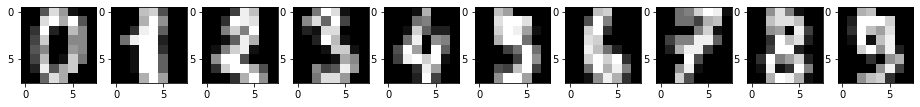

In [156]:
plt.figure(figsize=(16, 6))
width = int(np.sqrt(X.shape[1]))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i,:].reshape([width,width]), cmap='gray')

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

 - DecisionTreeClassifier с параметрами по-умолчанию

In [162]:
params = {

         }
GridSearchModel(DecisionTreeClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 67 ms, sys: 8.02 ms, total: 75 ms
Wall time: 215 ms
DecisionTreeClassifier

BEST:
mean_test_score=0.8520049658597145
params={}


 - BaggingClassifier с 100 деревьев  

In [163]:
params = {
            "n_estimators": [100]    
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 1.61 s, sys: 0 ns, total: 1.61 s
Wall time: 9.71 s
BaggingClassifier

BEST:
mean_test_score=0.9532464307883302
params={'n_estimators': 100}


 - BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев.

In [164]:
params = {
            "n_estimators": [100],
            "bootstrap_features": [True], # означает, что ограничение действует на каждый бутсрэп
            "max_features": [int(np.sqrt(df.shape[1]))]
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 335 ms, sys: 3.24 ms, total: 338 ms
Wall time: 2.09 s
BaggingClassifier

BEST:
mean_test_score=0.8753320918684049
params={'bootstrap_features': True, 'max_features': 3, 'n_estimators': 100}


- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев

In [165]:
params = {
            "n_estimators": [100],
            "max_features": [int(np.sqrt(df.shape[1]))]
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 2.18 s
BaggingClassifier

BEST:
mean_test_score=0.8775729360645561
params={'max_features': 3, 'n_estimators': 100}


 - обычный случайный лес со 100 деревьями

In [166]:
params = {
            "n_estimators": [100],
            "max_depth": np.linspace(1, 32, 20, endpoint=True),
            "max_features": [X_train.shape[1],int(X_train.shape[1]/2)] 
         }
GridSearchModel(RandomForestClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 2.84 s, sys: 138 ms, total: 2.98 s
Wall time: 1min 25s
RandomForestClassifier

BEST:
mean_test_score=0.9799658597144631
params={'max_depth': 27.105263157894736, 'max_features': 11, 'n_estimators': 100}


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [167]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
params = {
            "n_estimators": [1,5,10,15,50,100,150,200,300]
         }
search = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    

%time search.fit(X, y)   

CPU times: user 1.09 s, sys: 19.4 ms, total: 1.11 s
Wall time: 20.4 s


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sco

In [188]:
print("BEST: mean_test_score={} params={}".format(search.best_score_, search.best_params_))

BEST: mean_test_score=0.9794134078212291 params={'n_estimators': 200}


In [227]:
search.cv_results_

{'mean_fit_time': array([0.00807188, 0.02665777, 0.04677098, 0.06443763, 0.22519996,
        0.46411202, 0.66554236, 0.88483565, 1.30431068]),
 'std_fit_time': array([0.00090661, 0.00463906, 0.00277413, 0.001401  , 0.00842452,
        0.01727233, 0.02923891, 0.0440748 , 0.05336239]),
 'mean_score_time': array([0.00157437, 0.00198231, 0.00278986, 0.0035641 , 0.01039858,
        0.01992393, 0.02640288, 0.03585474, 0.05067432]),
 'std_score_time': array([0.00044492, 0.00029632, 0.00044614, 0.00030618, 0.00187228,
        0.00362326, 0.00131744, 0.00271279, 0.00053212]),
 'param_n_estimators': masked_array(data=[1, 5, 10, 15, 50, 100, 150, 200, 300],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1},
  {'n_estimators': 5},
  {'n_estimators': 10},
  {'n_estimators': 15},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 150},
  {'n_estim

In [221]:
search.cv_results_['mean_test_score']

array([0.79687151, 0.9254221 , 0.95326505, 0.96217256, 0.97329299,
       0.975509  , 0.97608007, 0.97662942, 0.97941341])

In [225]:
search.cv_results_['param_n_estimators']

masked_array(data=[1, 5, 10, 15, 50, 100, 150, 200, 300],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object)

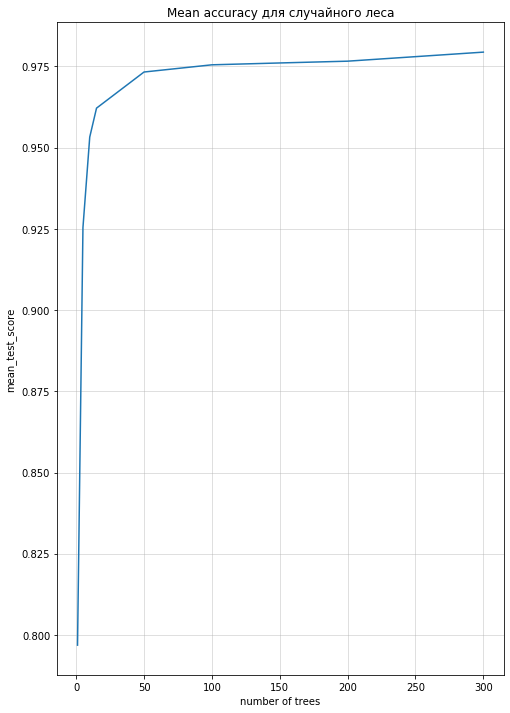

In [224]:
fig, ax = plt.subplots(figsize=(8, 12))
plt.title('Mean accuracy для случайного леса')
ax.set_xlabel('number of trees')
ax.set_ylabel('mean_test_score')

plt.grid(alpha=0.5)
sns.lineplot(x=search.cv_results_['param_n_estimators'], y=search.cv_results_['mean_test_score']);

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)